# **<span style="color:red">Imports</span>**

In [1]:
# Handy arrays
import numpy as np

# FFTs
import scipy.fft as fft
import scipy.fftpack as fftp

# Custom modules
import lib.utils.utils as Utils
import lib.utils.plotting as Plotting
import lib.utils.otf as OTF
import lib.methods.distortion as Distortion
import lib.methods.tikhonov_rgb as Restoration
import lib.mag.sample_presets as SamplePresets
import lib.scripts as Scripts

# **<span style="color:red">Reconstruction of simulated samples</span>**

## <span style="color:orange">**Samples init**</span>

### <span>**Samples**</span>

In [ ]:
# Sample 1
image = Utils.create_image((2048, 2048), mode='rgb')
window_func = Utils.create_super_gauss(image.shape[0:2], 10.8/11, 10, mode='square')
sample_preset_1 = SamplePresets.SimulatedSamplePreset(Utils.rgb_mul_mono(image, window_func), 'Results_(Mag)/Simulated_Sample_1/',
                                                      np.loadtxt("Data/detector_funcs.csv", delimiter=";"),
                                                      0.001, 0.01, 0.5,
                                                      None, None,
                                                      0.05, 300, None,
                                                      np.zeros(image.shape[0:2]) + 1e+5, 100)

In [ ]:
# Sample 2
image = Utils.create_image((2048, 2048), mode='rgb')
window_func = Utils.create_super_gauss(image.shape[0:2], 10.8/11, 10, mode='square')
sample_preset_2 = SamplePresets.SimulatedSamplePreset(Utils.rgb_mul_mono(image, window_func), 'Results_(Mag)/Simulated_Sample_2/',
                                                      np.loadtxt("Data/detector_funcs.csv", delimiter=";"),
                                                      0.001, 0.01, 0.5,
                                                      None, None,
                                                      0.05, 900, None,
                                                      np.zeros(image.shape[0:2]) + 1e+5, 100)

In [2]:
# Sample 3
image = Utils.create_image((2048, 2048), mode='rgb')
image[:,:,2] *= 0.5
window_func = Utils.create_super_gauss(image.shape[0:2], 10.8/11, 10, mode='square')
sample_preset_3 = SamplePresets.SimulatedSamplePreset(Utils.rgb_mul_mono(image, window_func), 'Results_(Mag)/Simulated_Sample_3/',
                                                      np.loadtxt("Data/detector_funcs.csv", delimiter=";"),
                                                      0.001, 0.01, 0.5,
                                                      None, None,
                                                      0.05, 900, Utils.image_load('Samples/Test_noise_2_p.png', mode='rgb'),
                                                      [70, 0.9], 100)

In [3]:
# Sample choice
selected_sample = sample_preset_3

### <span>**Detector Functions**</span>

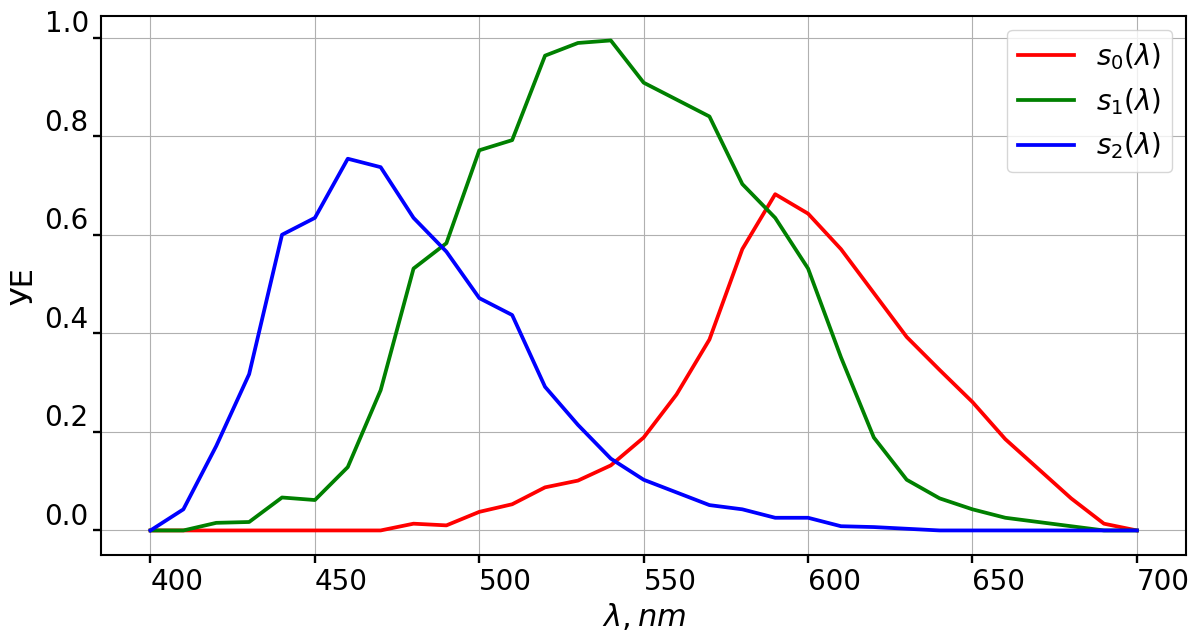

In [4]:
Plotting.plot_functions([Plotting.FuncDesc(selected_sample.detector_funcs[0], selected_sample.detector_funcs[1], r'$s_{0}(\lambda)$', 'r'),
                         Plotting.FuncDesc(selected_sample.detector_funcs[0], selected_sample.detector_funcs[2], r'$s_{1}(\lambda)$', 'g'),
                         Plotting.FuncDesc(selected_sample.detector_funcs[0], selected_sample.detector_funcs[3], r'$s_{2}(\lambda)$', 'b')],
                        x_axis_name=r'$\lambda, nm$', plot_file=selected_sample.sample_folder + '2-1.svg')

### <span>**Image**</span>

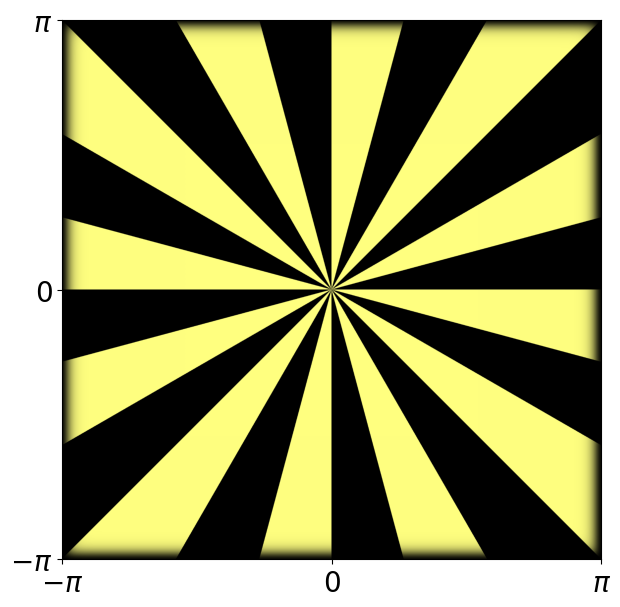

In [4]:
Plotting.plot_image(selected_sample.image)

In [6]:
Utils.image_save(Utils.image_crop_corners(selected_sample.image), selected_sample.sample_folder + '1, original.png', mode='rgb')

## <span style="color:orange">**OTF batch**</span>

In [4]:
otf_batch = OTF.create_otf_batch(selected_sample.image.shape[0:2], selected_sample.image_rgb_ratios,
                                 selected_sample.detector_funcs, selected_sample.defocus_a, selected_sample.focus_wlength)

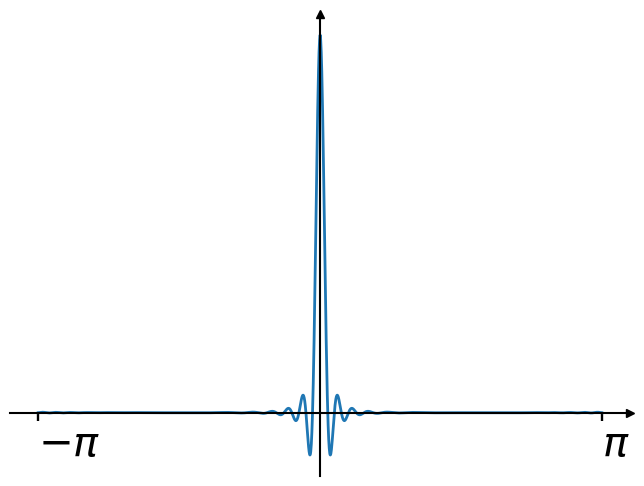

In [8]:
Plotting.plot_image(fftp.fftshift(otf_batch[0,0,:,:].real), plot_image=False, plot_cut=True, cut_index=selected_sample.image.shape[0]//2,
                    y_axis_position=-0.5, plot_file=selected_sample.sample_folder + '2-2.svg')

## **<span style="color:orange">Image blurring</span>**

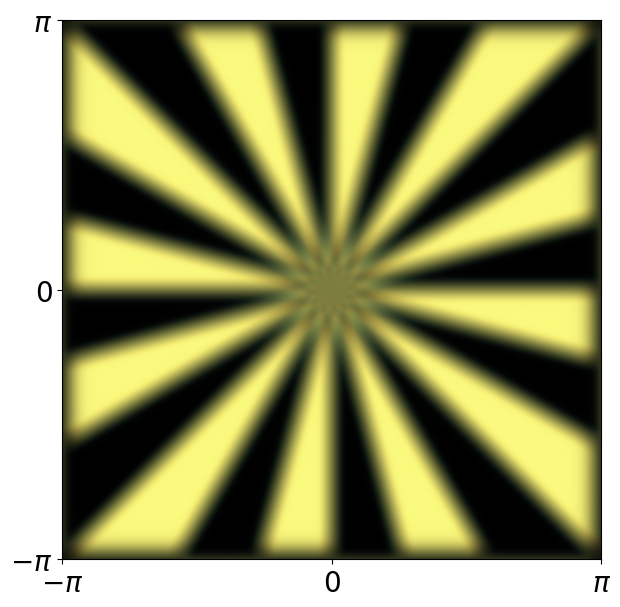

In [15]:
image_blurred = Distortion.image_distortion_rgb(selected_sample.image, otf_batch, selected_sample.additive_noise)
Plotting.plot_image(image_blurred)

In [ ]:
Utils.image_save(Utils.image_crop_corners(image_blurred), selected_sample.sample_folder + '3, observed.png', mode='rgb')

## **<span style="color:orange">Defocus parameters restoration</span>**

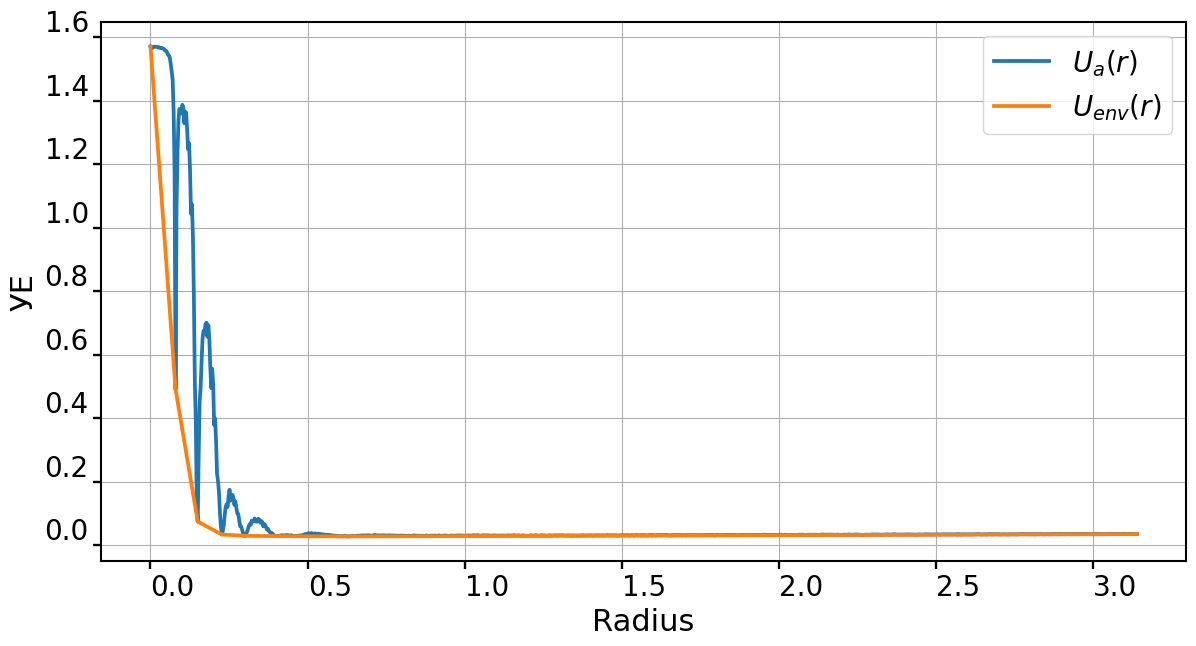

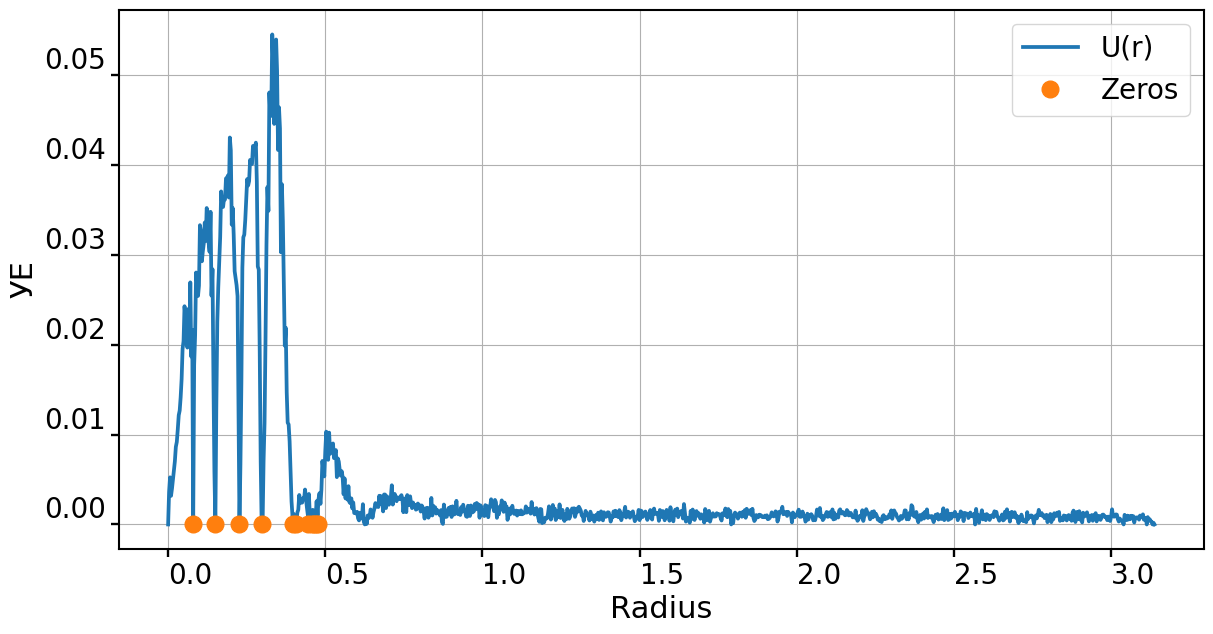

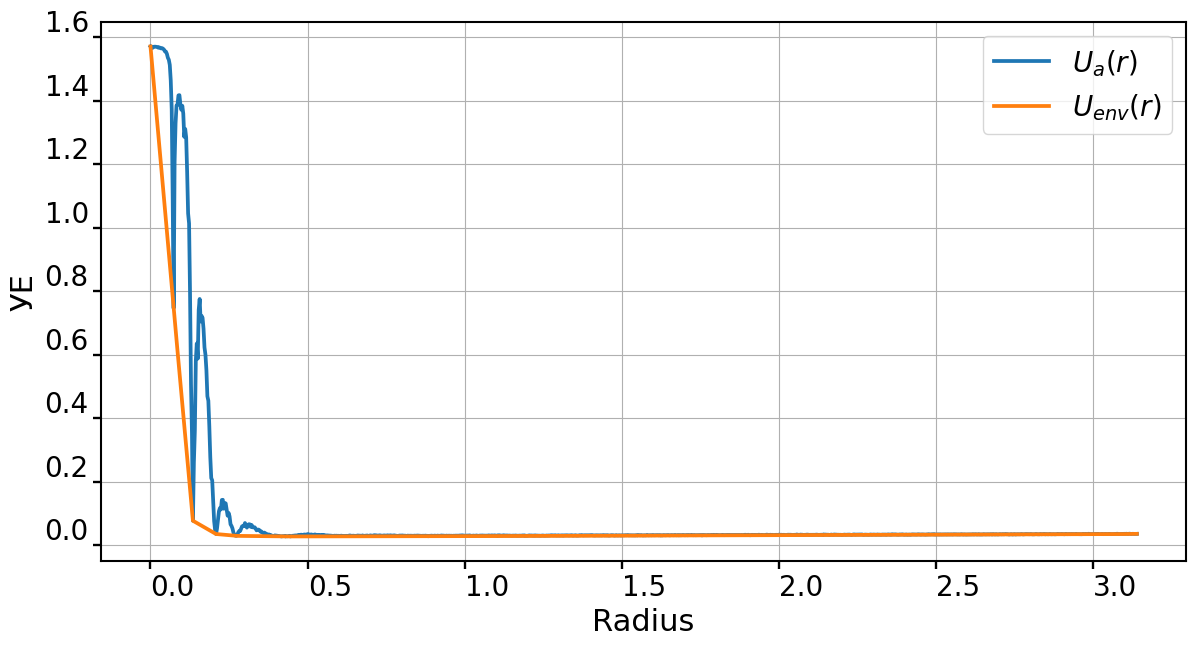

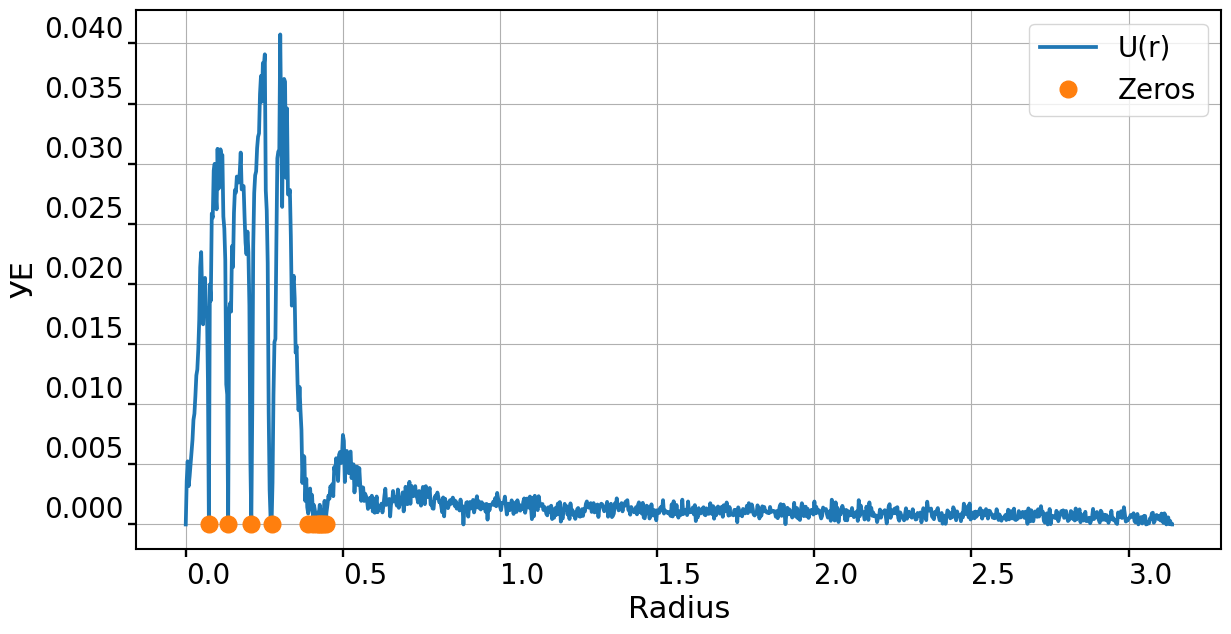

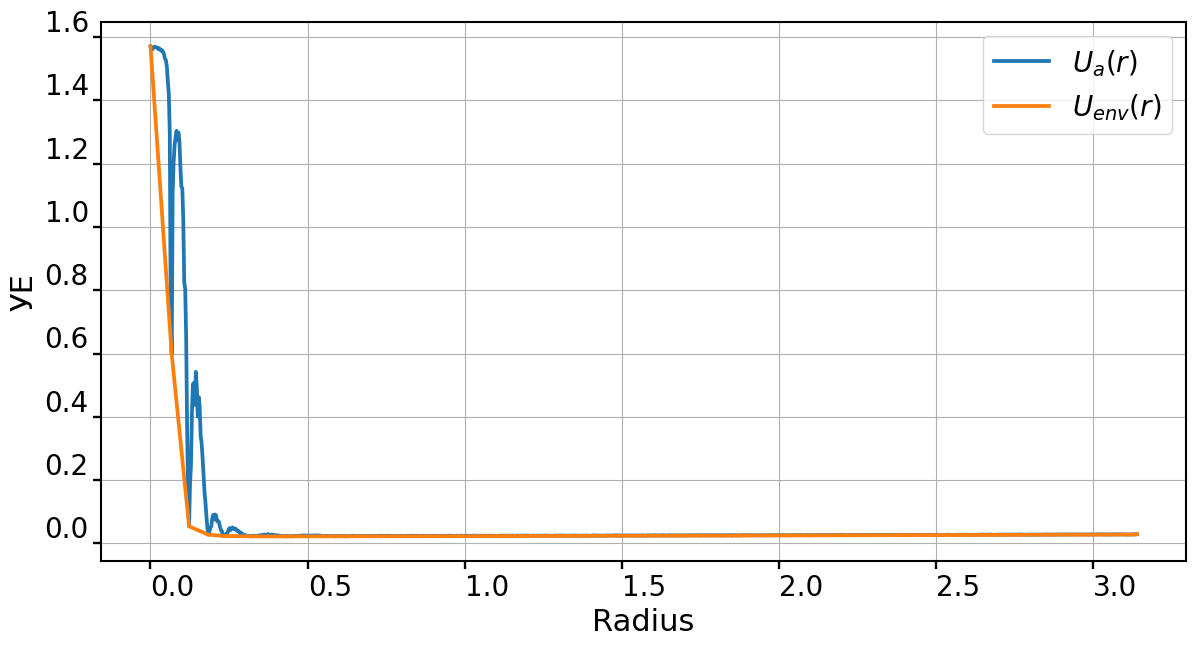

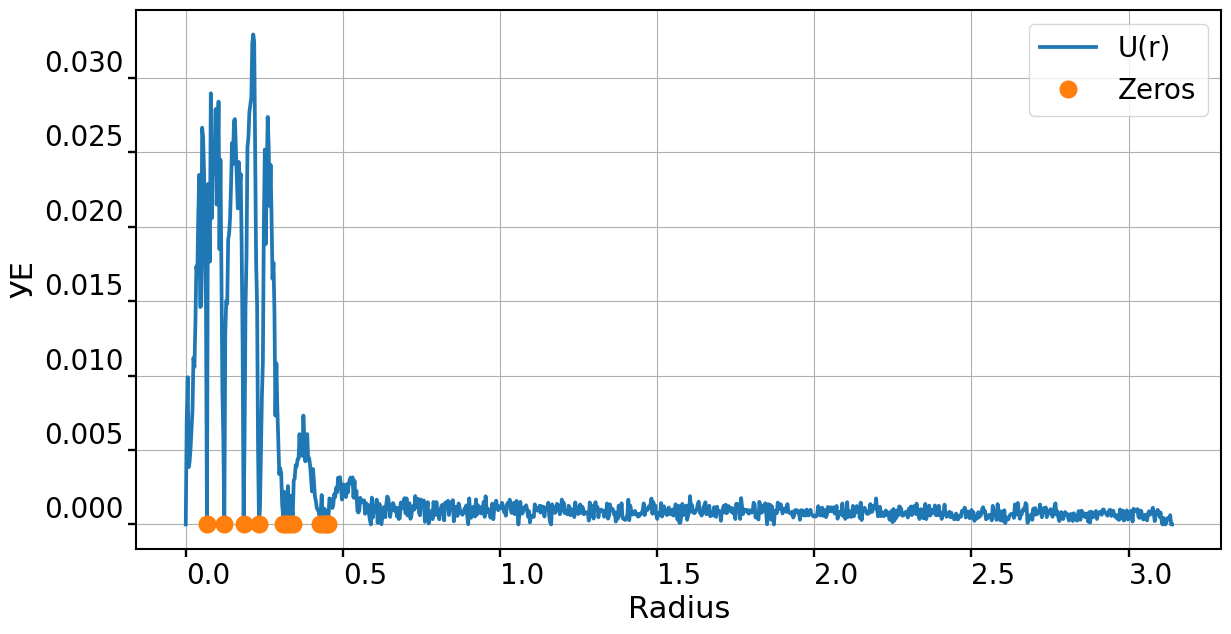

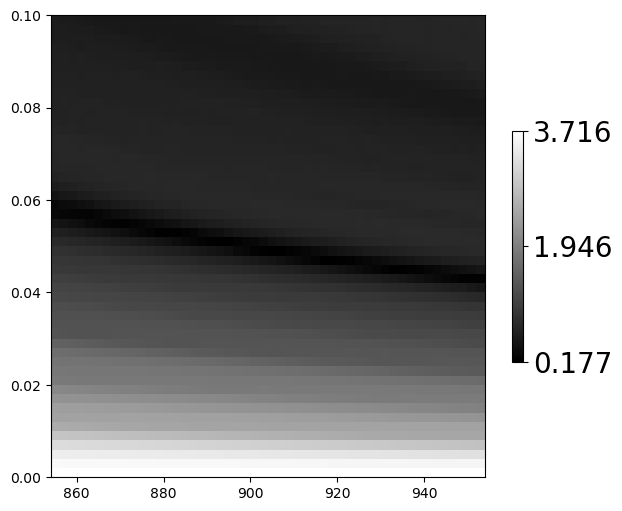

In [ ]:
fn_v = Scripts.estimate_defocus_param_rgb(image_blurred,
                                          selected_sample.average_angled_spectrum_k, selected_sample.average_angled_spectrum_b,
                                          selected_sample.zeros_range_ratio,
                                          selected_sample.image_rgb_ratios, selected_sample.detector_funcs,
                                          a=selected_sample.defocus_a_grid, wlength0=selected_sample.focus_wlength_grid,
                                          plot_folder=selected_sample.sample_folder)

## **<span style="color:orange">Image restoration</span>**

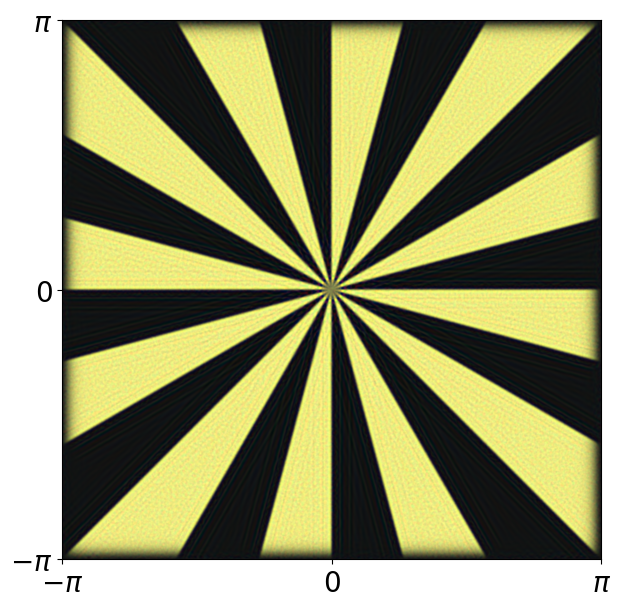

In [ ]:
image_restored, nev_norm = Restoration.tikhonov_regularization_method_rgb(image_blurred, otf_batch, selected_sample.mu, selected_sample.k0)
Plotting.plot_image(image_restored)